In [1]:
from fraggler2 import fraggler

[INFO]: Starting fraggler, importing libraries...


## Fsa file object

Start with creating a fsa object:

In [4]:
fsa = fraggler.FsaFile(
    file="demo/multiplex.fsa",
    ladder="LIZ",
    sample_channel="DATA1",
    min_distance_between_peaks=30,
    min_size_standard_height=100
)



            Filename: multiplex.fsa
            Sample Channel: DATA1
            Size Standard Channel: DATA205
            Ladder Name: LIZ
            Number of Ladder Steps: 35
            Minimum Distance Between Peaks: 30
            Minimum Size Standard Height: 100
            Normalized Data: False
            Ladder Steps: [ 20  40  60  80 100 114 120 140 160 180 200 214 220 240 260 280 300 314
 320 340 360 380 400 414 420 440 460 480 500 514 520 540 560 580 600]
            Fitted to model: False
            Found peaks: False
            

## Continue updating the fsa object with useful functions

Here we find the size standard peaks from the identified size standard channel

In [8]:
fsa = fraggler.find_size_standard_peaks(fsa)

fsa.size_standard_peaks

array([1020, 1151, 1263, 1407, 1561, 1721, 1834, 1884, 2054, 2221, 2391,
       2562, 2683, 2735, 2911, 2997, 3086, 3262, 3441, 3566, 3618, 3796,
       3973, 4150, 4324, 4447, 4498, 4669, 4836, 5002, 5161, 5270, 5316,
       5469, 5614, 5753, 5887])

To find the correct combinations of peaks from the size standard data, we have to estimate a good distance between peaks to limit the amount of combinations that can be generated. With the below function, be calculate the mean length between each peak and multiplies that with the value of the multiplier

In [11]:
fsa = fraggler.return_maxium_allowed_distance_between_size_standard_peaks(
    fsa, multiplier=2
)

fsa.maxium_allowed_distance_between_size_standard_peaks

270

Here, we generate all possible combinations using the diff value calculated above and a depth first search algorithm. 

In [39]:
fsa = fraggler.generate_combinations(fsa)
fsa.best_size_standard_combinations

,combinations
0,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
1,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
2,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
3,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
4,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
...,...
139,"[1151, 1263, 1407, 1561, 1721, 1834, 1884, 205..."
140,"[1151, 1263, 1407, 1561, 1721, 1834, 2054, 222..."
141,"[1151, 1263, 1407, 1561, 1721, 1884, 2054, 222..."
142,"[1151, 1407, 1561, 1721, 1834, 1884, 2054, 222..."


Next, using the second derivative, we identifies which of all combinations fits the ladder steps the best 

In [40]:
fsa = fraggler.calculate_best_combination_of_size_standard_peaks(fsa)


fsa.best_size_standard

array([1151, 1263, 1407, 1561, 1721, 1834, 1884, 2054, 2221, 2391, 2562,
       2683, 2735, 2911, 3086, 3262, 3441, 3566, 3618, 3796, 3973, 4150,
       4324, 4447, 4498, 4669, 4836, 5002, 5161, 5270, 5316, 5469, 5614,
       5753, 5887])

Using the best size standard from above, we fit a model using the ladder steps

In [41]:
fsa = fraggler.fit_size_standard_to_ladder(fsa)

fsa.ladder_model

Pipeline(steps=[('splinetransformer',
                 SplineTransformer(degree=2, extrapolation='continue',
                                   n_knots=3)),
                ('linearregression', LinearRegression())])

The fitted model is used to convert time to basepairs in the sample data channel

In [42]:
fsa.sample_data_with_basepairs

,time,peaks,basepairs
967,967,302,0.05
968,968,312,0.19
969,969,340,0.32
970,970,377,0.45
971,971,425,0.59
...,...,...,...
6599,6599,1,697.73
6600,6600,6,697.87
6601,6601,5,698.02
6602,6602,7,698.16


## Find peaks


We can use two modes to find peaks
- agnostic
- custom

### Agnostic peak finding

In [21]:
fsa = fraggler.find_peaks_agnostic(
    fsa,
    peak_height_sample_data=300,
    min_ratio=0.15,
    distance_between_assays=30,
    search_peaks_start=115,
)

In [43]:
fsa.identified_sample_data_peaks

,time,peaks,basepairs,peaks_index,peak_name,difference,assay,max_peak,ratio,model,r_value,quotient
0,2060,782,140.68,207,1,100.00,10,1399,0.558971,gauss,0.996,1.743288
17,2145,1399,151.08,292,2,10.40,10,1399,1.000000,gauss,0.996,1.743288
34,2518,711,195.82,665,3,44.74,30,1548,0.459302,gauss,0.985,2.150499
52,2545,1548,199.00,692,4,3.18,30,1548,1.000000,gauss,0.985,2.150499
70,2807,1601,229.45,954,5,30.45,50,1601,1.000000,gauss,0.996,0.602506
87,2846,969,233.93,993,6,4.48,50,1601,0.605247,gauss,0.996,0.602506
104,3131,1071,266.11,1278,7,32.18,70,2294,0.466870,gauss,0.992,2.351421
122,3160,945,269.33,1307,8,3.22,70,2294,0.411944,gauss,0.992,2.351421
140,3187,459,272.33,1334,9,3.00,70,2294,0.200087,gauss,0.992,2.351421
158,3239,1070,278.07,1386,10,5.74,70,2294,0.466434,gauss,0.992,2.351421


### Custom peak finding

The functions below reads and checks if the custom peaks csv is OK.
If there is a problem, the program will tell you.

In [45]:
custom_peaks = fraggler.read_valid_csv("demo/custom_peaks.csv")
fraggler.custom_peaks_are_overlapping(custom_peaks)
fraggler.custom_peaks_has_columns(custom_peaks)

The custom peak table MUST look like this (see more in README):

In [49]:
custom_peaks

,name,start,stop,amount,min_ratio,which,peak_distance
0,prt1,135,155,2,0.2,FIRST,NaN
1,prt3,190,205,2,0.2,FIRST,NaN
2,prt2,222,236,2,0.2,FIRST,5.0
3,prt4,262,290,5,0.2,LARGEST,NaN


Find the peaks using the customized table

In [47]:
fsa = fraggler.find_peaks_customized(
    fsa,
    custom_peaks,
    peak_height_sample_data=200,
    search_peaks_start=115,
)

In [48]:
fsa.identified_sample_data_peaks

,index,time,peaks,basepairs,peaks_index,assay,max_peak,ratio,peak_name
0,2060,2060,782,140.68,207,prt1,1399,0.558971,1
1,2145,2145,1399,151.08,292,prt1,1399,1.000000,2
2,2518,2518,711,195.82,665,prt3,1548,0.459302,3
3,2545,2545,1548,199.00,692,prt3,1548,1.000000,4
4,2807,2807,1601,229.45,954,prt2,1601,1.000000,5
5,2846,2846,969,233.93,993,prt2,1601,0.605247,6
6,3131,3131,1071,266.11,1278,prt4,2294,0.466870,7
7,3160,3160,945,269.33,1307,prt4,2294,0.411944,8
8,3187,3187,459,272.33,1334,prt4,2294,0.200087,9
9,3239,3239,1070,278.07,1386,prt4,2294,0.466434,10


## Area


Next, we find the areas of the identified peaks

You can choose between the "gauss", "lorentzian" and "voigt" distributions

In [50]:
fsa = fraggler.find_peak_widths(fsa)
fsa = fraggler.find_peaks_with_padding(fsa)
fsa = fraggler.fit_lmfit_model_to_area(fsa, "gauss")

fsa.fitted_area_peaks

,time,peaks,basepairs,assay,peak_name,fitted,model,amplitude,center,sigma,fwhm,fit_report,r_value
2051,2051,31,139.57,prt1,1,0.000114,gauss,3096.099821,2059.583026,1.527991,3.598143,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
2052,2052,23,139.70,prt1,1,0.003627,gauss,3096.099821,2059.583026,1.527991,3.598143,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
2053,2053,18,139.82,prt1,1,0.075345,gauss,3096.099821,2059.583026,1.527991,3.598143,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
2054,2054,13,139.94,prt1,1,1.019947,gauss,3096.099821,2059.583026,1.527991,3.598143,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
2055,2055,18,140.07,prt1,1,8.996753,gauss,3096.099821,2059.583026,1.527991,3.598143,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,3272,168,281.71,prt4,11,123.617011,gauss,10770.782958,3267.559617,1.829870,4.309014,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.993
3273,3273,92,281.82,prt4,11,28.268637,gauss,10770.782958,3267.559617,1.829870,4.309014,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.993
3274,3274,60,281.93,prt4,11,4.795461,gauss,10770.782958,3267.559617,1.829870,4.309014,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.993
3275,3275,46,282.04,prt4,11,0.603469,gauss,10770.782958,3267.559617,1.829870,4.309014,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.993


Look at the fit report from the area fit function

In [51]:
print(fsa.fitted_area_peaks.fit_report.iloc[0])

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 17
    # variables        = 3
    chi-square         = 4115.99541
    reduced chi-square = 293.999672
    Akaike info crit   = 99.3201849
    Bayesian info crit = 101.819825
    R-squared          = 0.99640354
[[Variables]]
    amplitude:  3096.09982 +/- 48.8744258 (1.58%) (init = 3460.5)
    center:     2059.58303 +/- 0.02785201 (0.00%) (init = 2059.5)
    sigma:      1.52799053 +/- 0.02785202 (1.82%) (init = 1.5)
    fwhm:       3.59814265 +/- 0.06558648 (1.82%) == '2.3548200*sigma'
    height:     808.359189 +/- 12.7605972 (1.58%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


Calculate the quotients between the peaks in each identified assay and update the sample peak table

In [52]:
fsa = fraggler.calculate_quotients(fsa)
fsa = fraggler.update_identified_sample_data_peaks(fsa)

fsa.identified_sample_data_peaks

,index,time,peaks,basepairs,peaks_index,assay,max_peak,ratio,peak_name,model,r_value,quotient
0,2060,2060,782,140.68,207,prt1,1399,0.558971,1,gauss,0.996,1.743288
35,2145,2145,1399,151.08,292,prt1,1399,1.000000,2,gauss,0.996,1.743288
70,2518,2518,711,195.82,665,prt3,1548,0.459302,3,gauss,0.985,2.150499
106,2545,2545,1548,199.00,692,prt3,1548,1.000000,4,gauss,0.985,2.150499
142,2807,2807,1601,229.45,954,prt2,1601,1.000000,5,gauss,0.996,0.602506
176,2846,2846,969,233.93,993,prt2,1601,0.605247,6,gauss,0.996,0.602506
210,3131,3131,1071,266.11,1278,prt4,2294,0.466870,7,gauss,0.992,2.351421
300,3160,3160,945,269.33,1307,prt4,2294,0.411944,8,gauss,0.992,2.351421
390,3187,3187,459,272.33,1334,prt4,2294,0.200087,9,gauss,0.992,2.351421
480,3239,3239,1070,278.07,1386,prt4,2294,0.466434,10,gauss,0.992,2.351421


## Plots

Below are examples of how to plot using fraggler

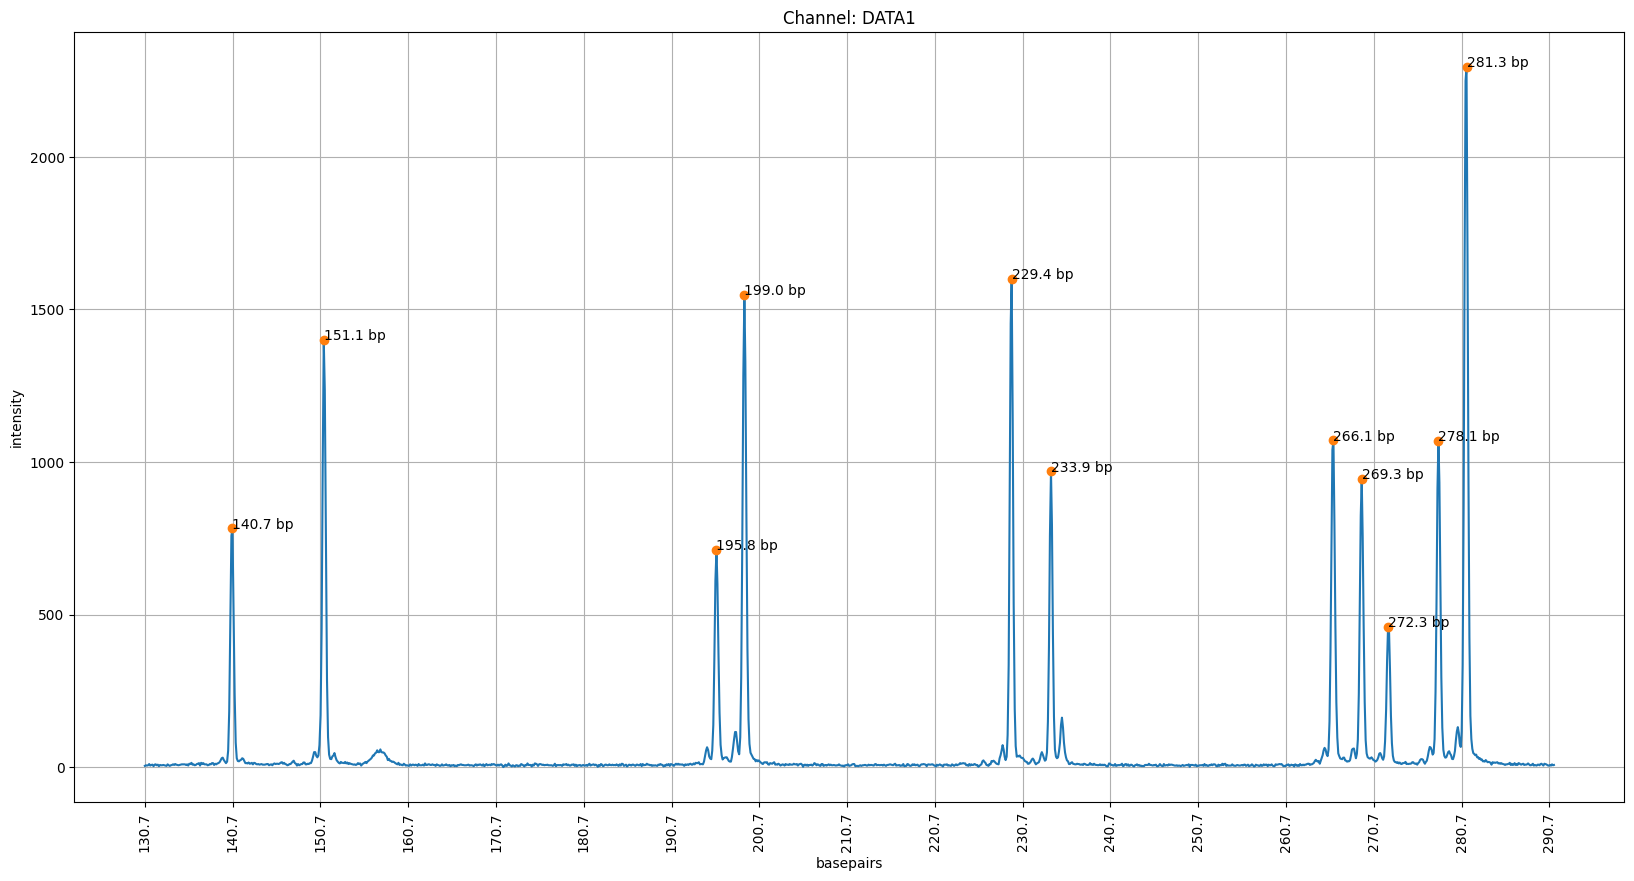

In [54]:
peaks_plot = fraggler.plot_all_found_peaks(fsa)

peaks_plot

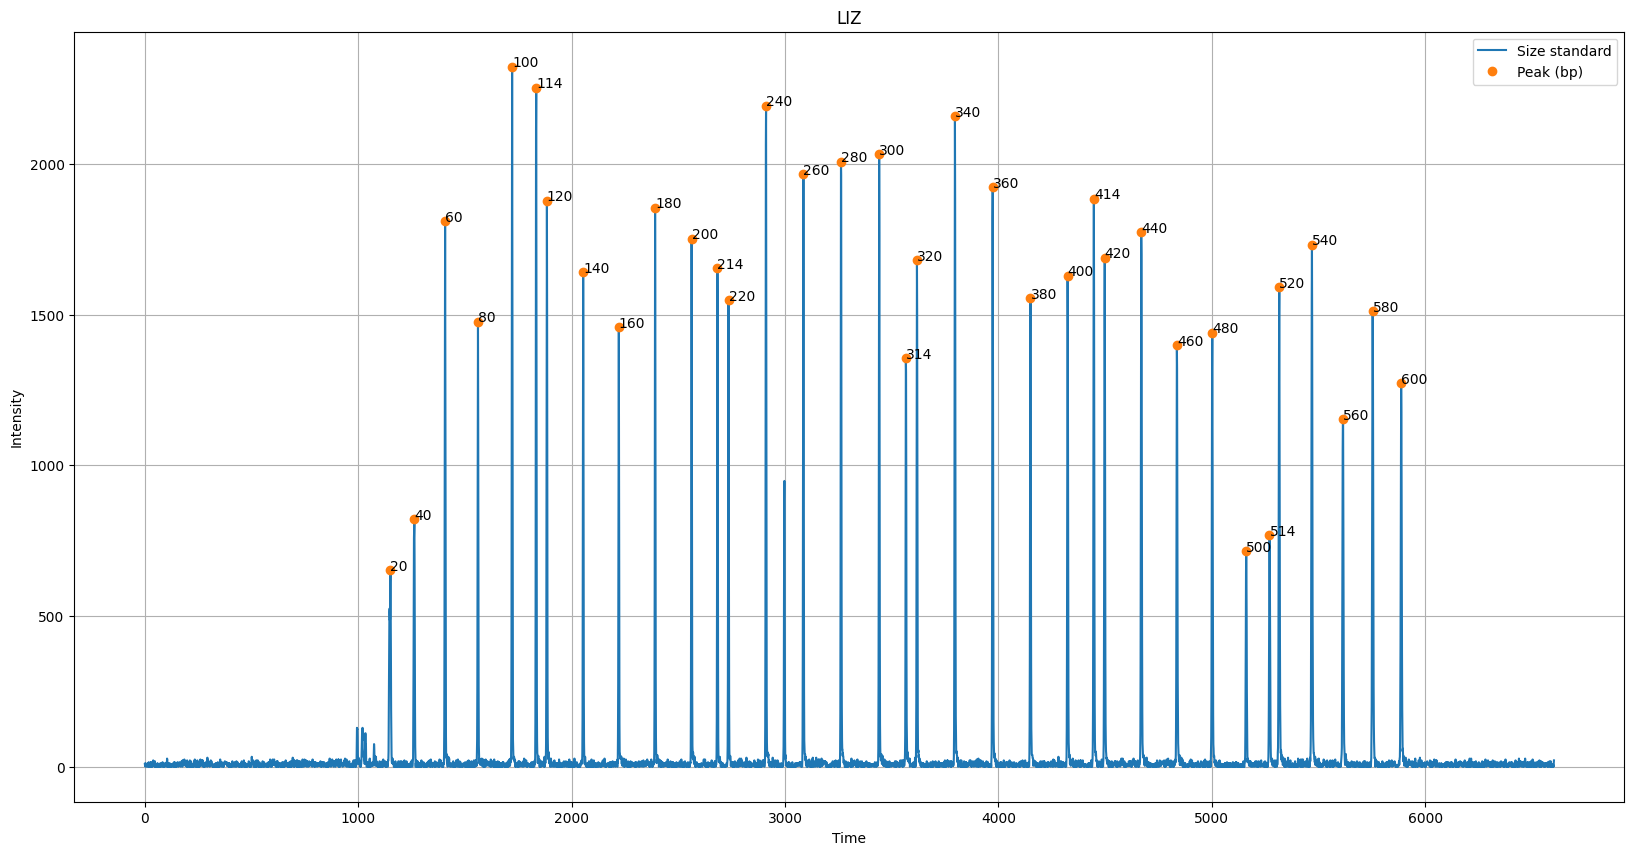

In [55]:
ladder_plot = fraggler.plot_size_standard_peaks(fsa)
ladder_plot

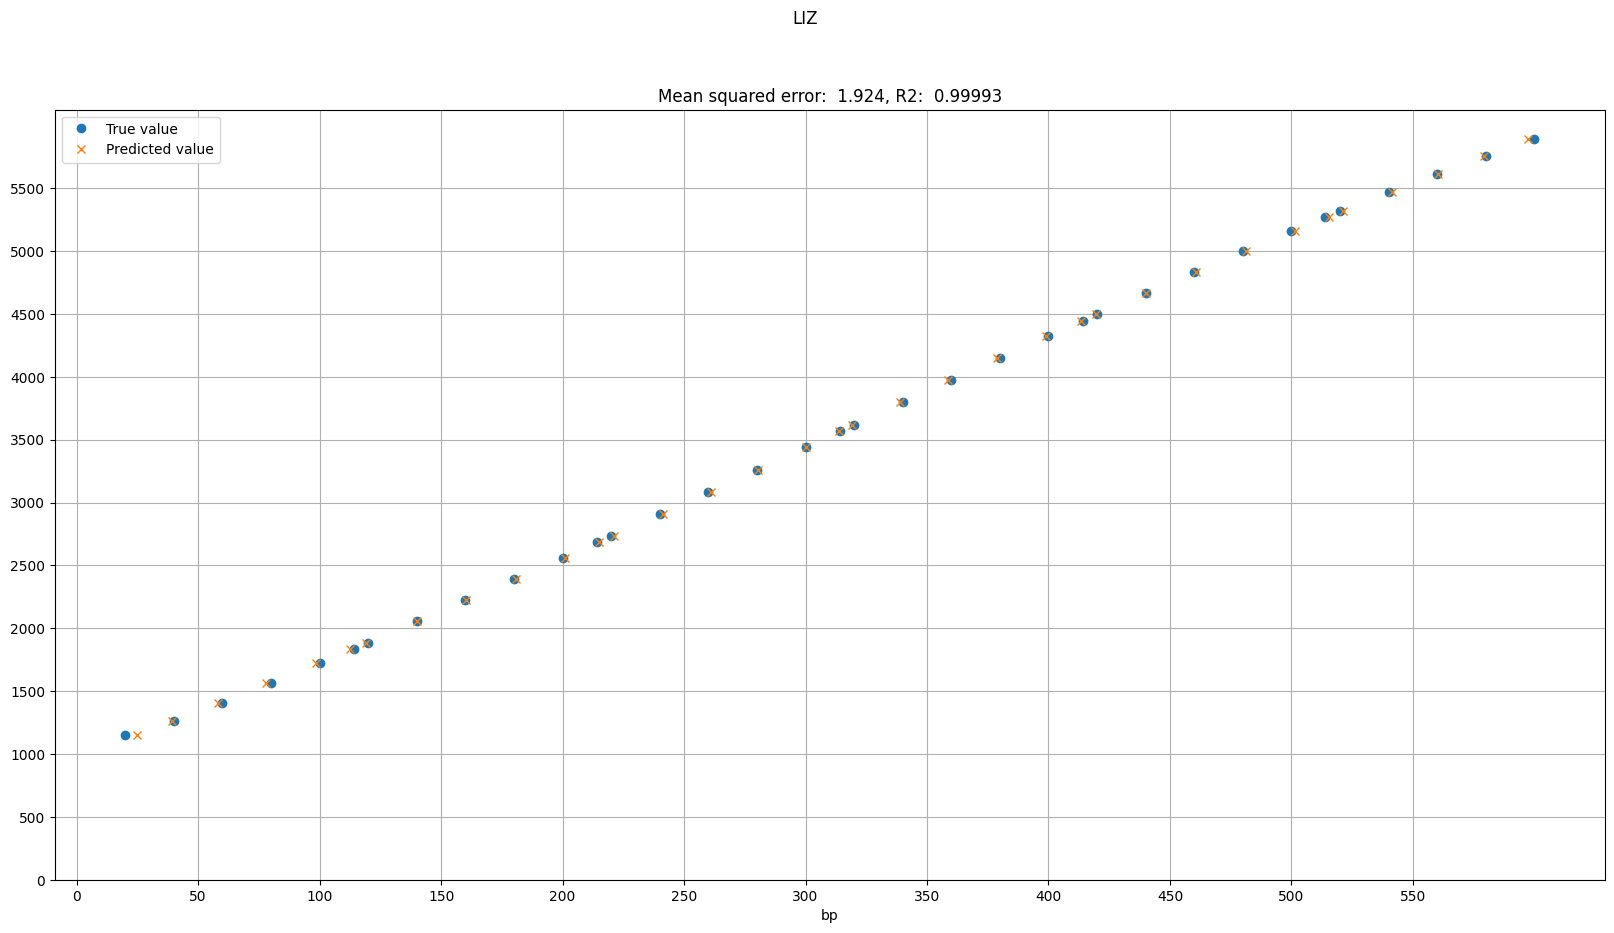

In [56]:
model_fit = fraggler.plot_model_fit(fsa)
model_fit

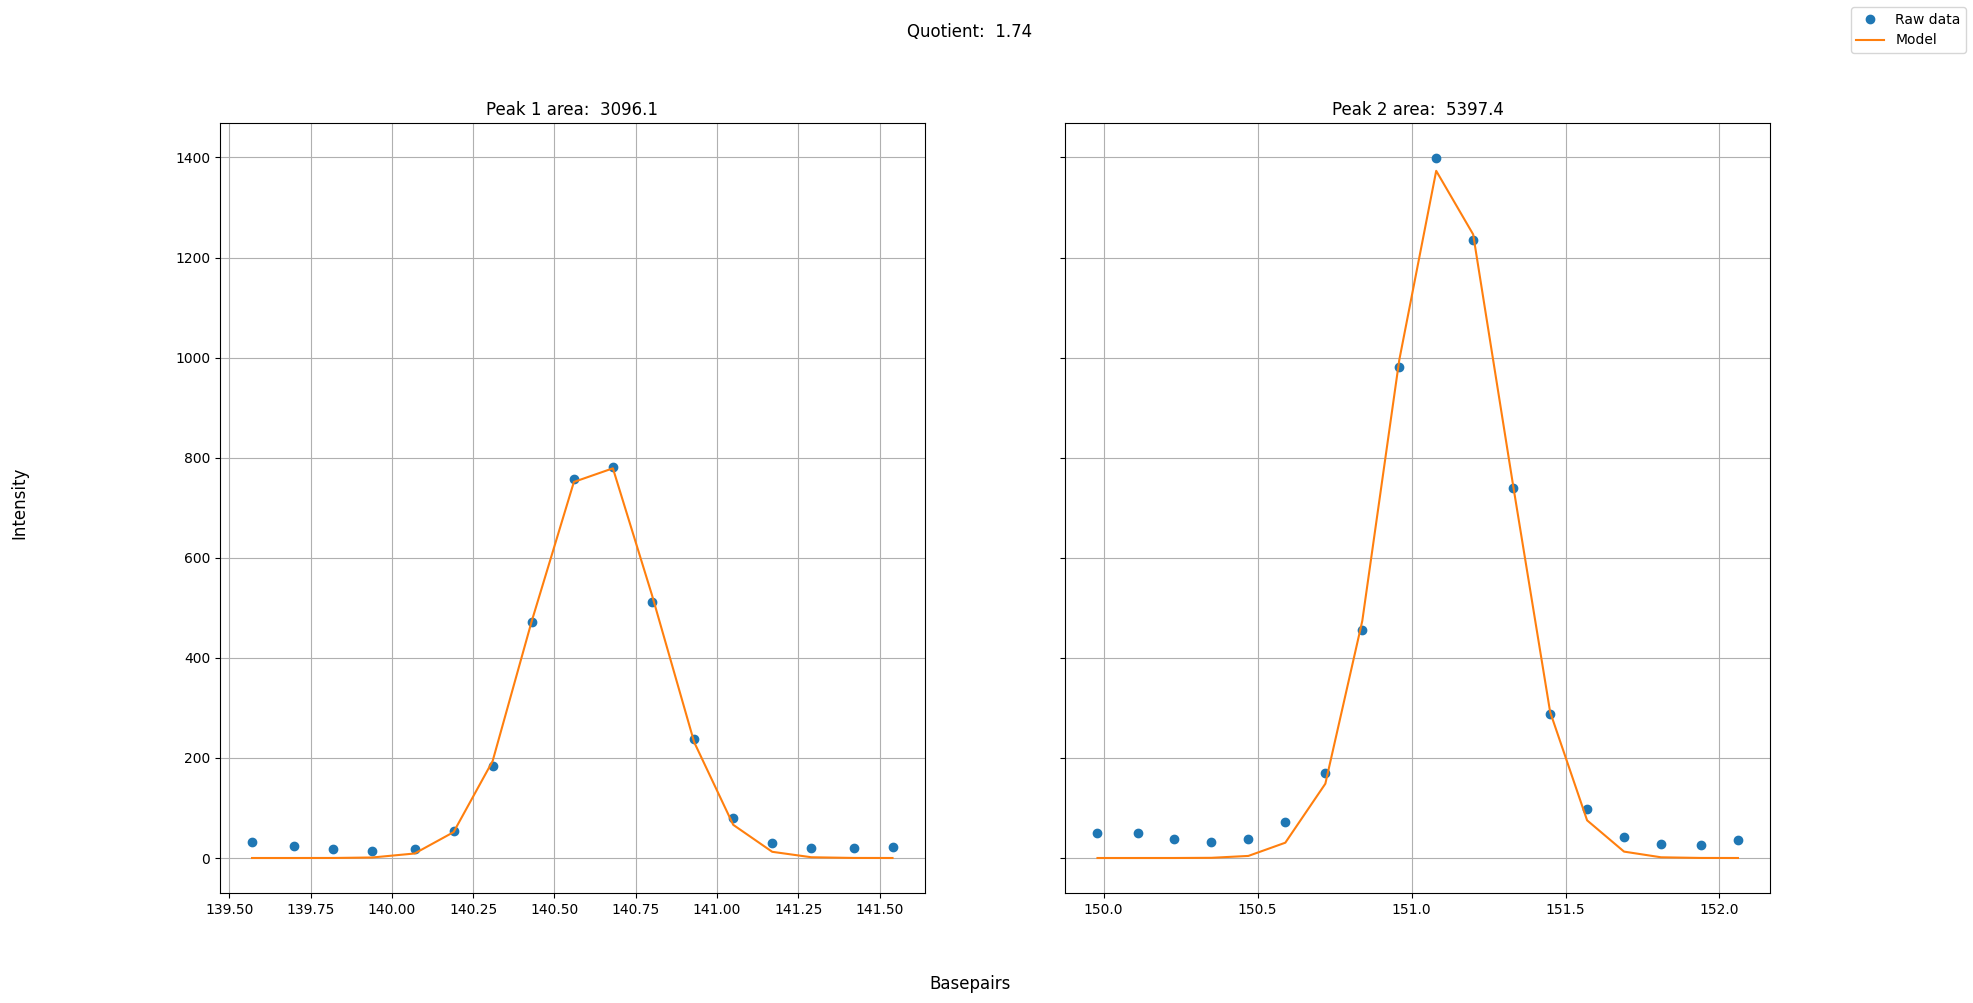

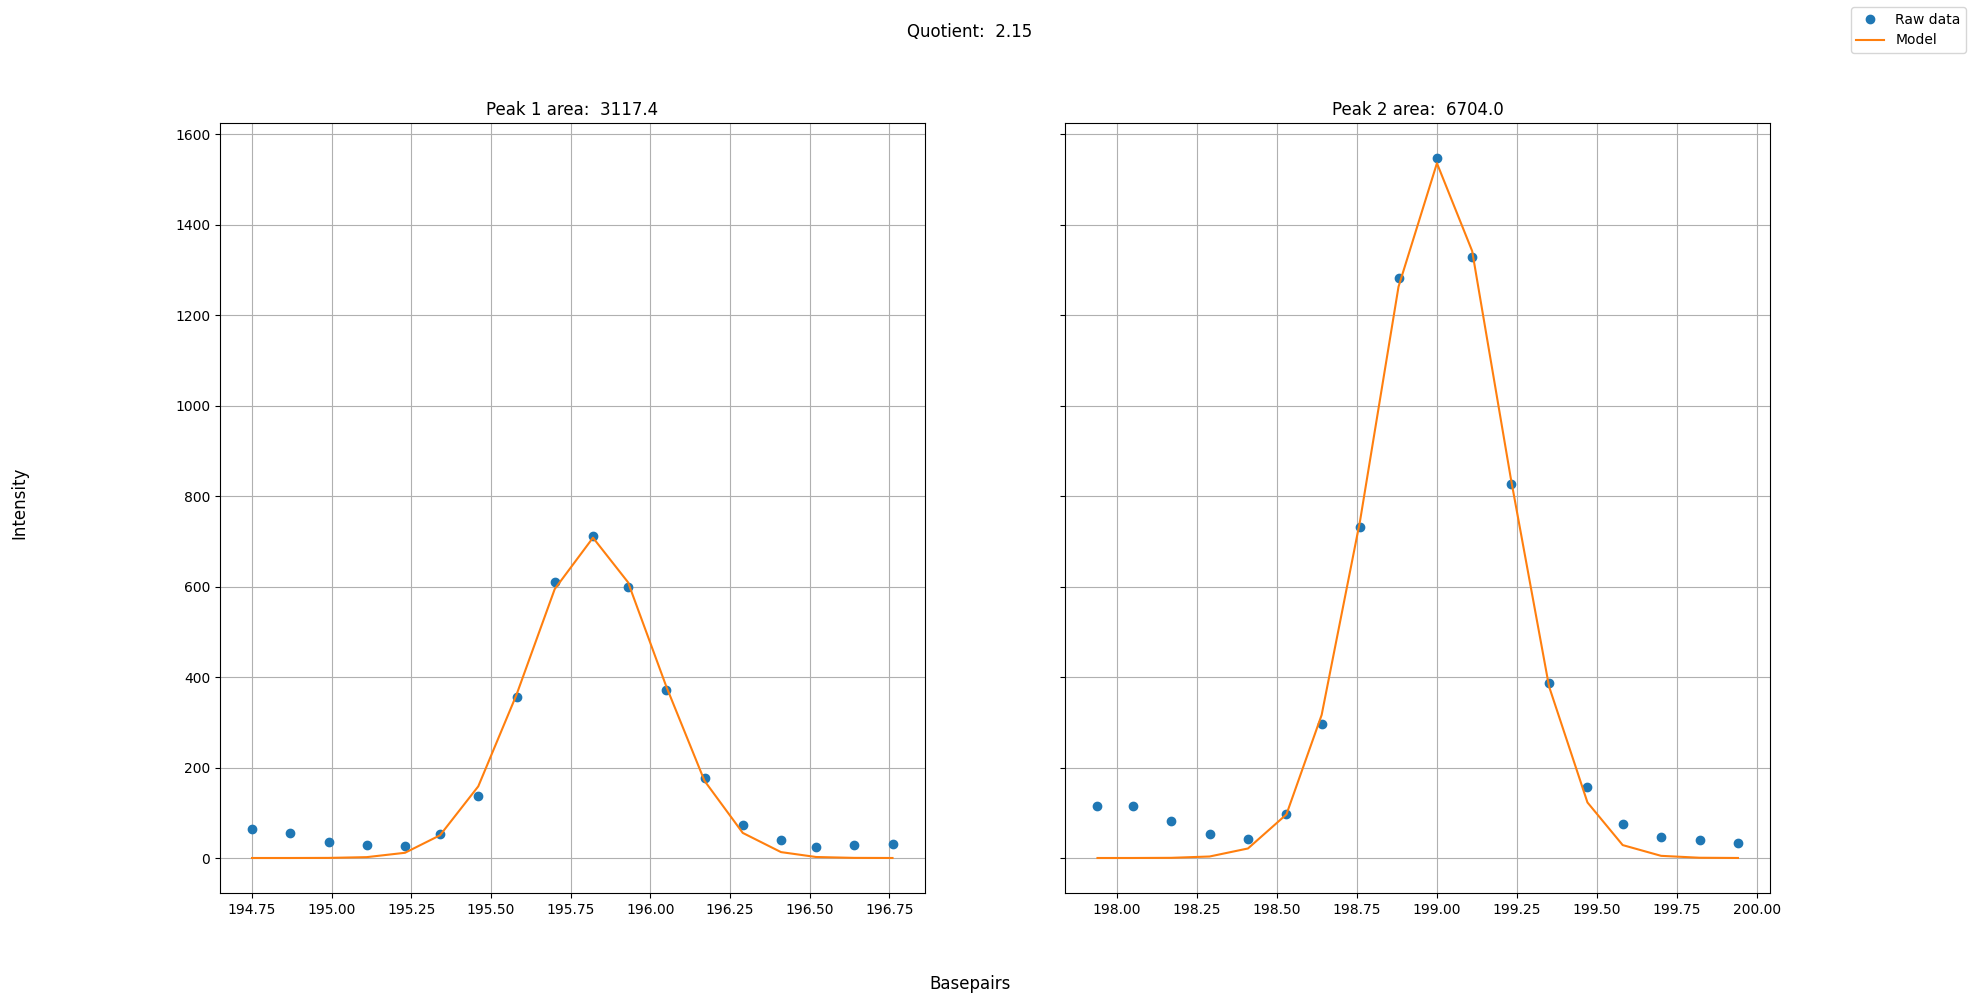

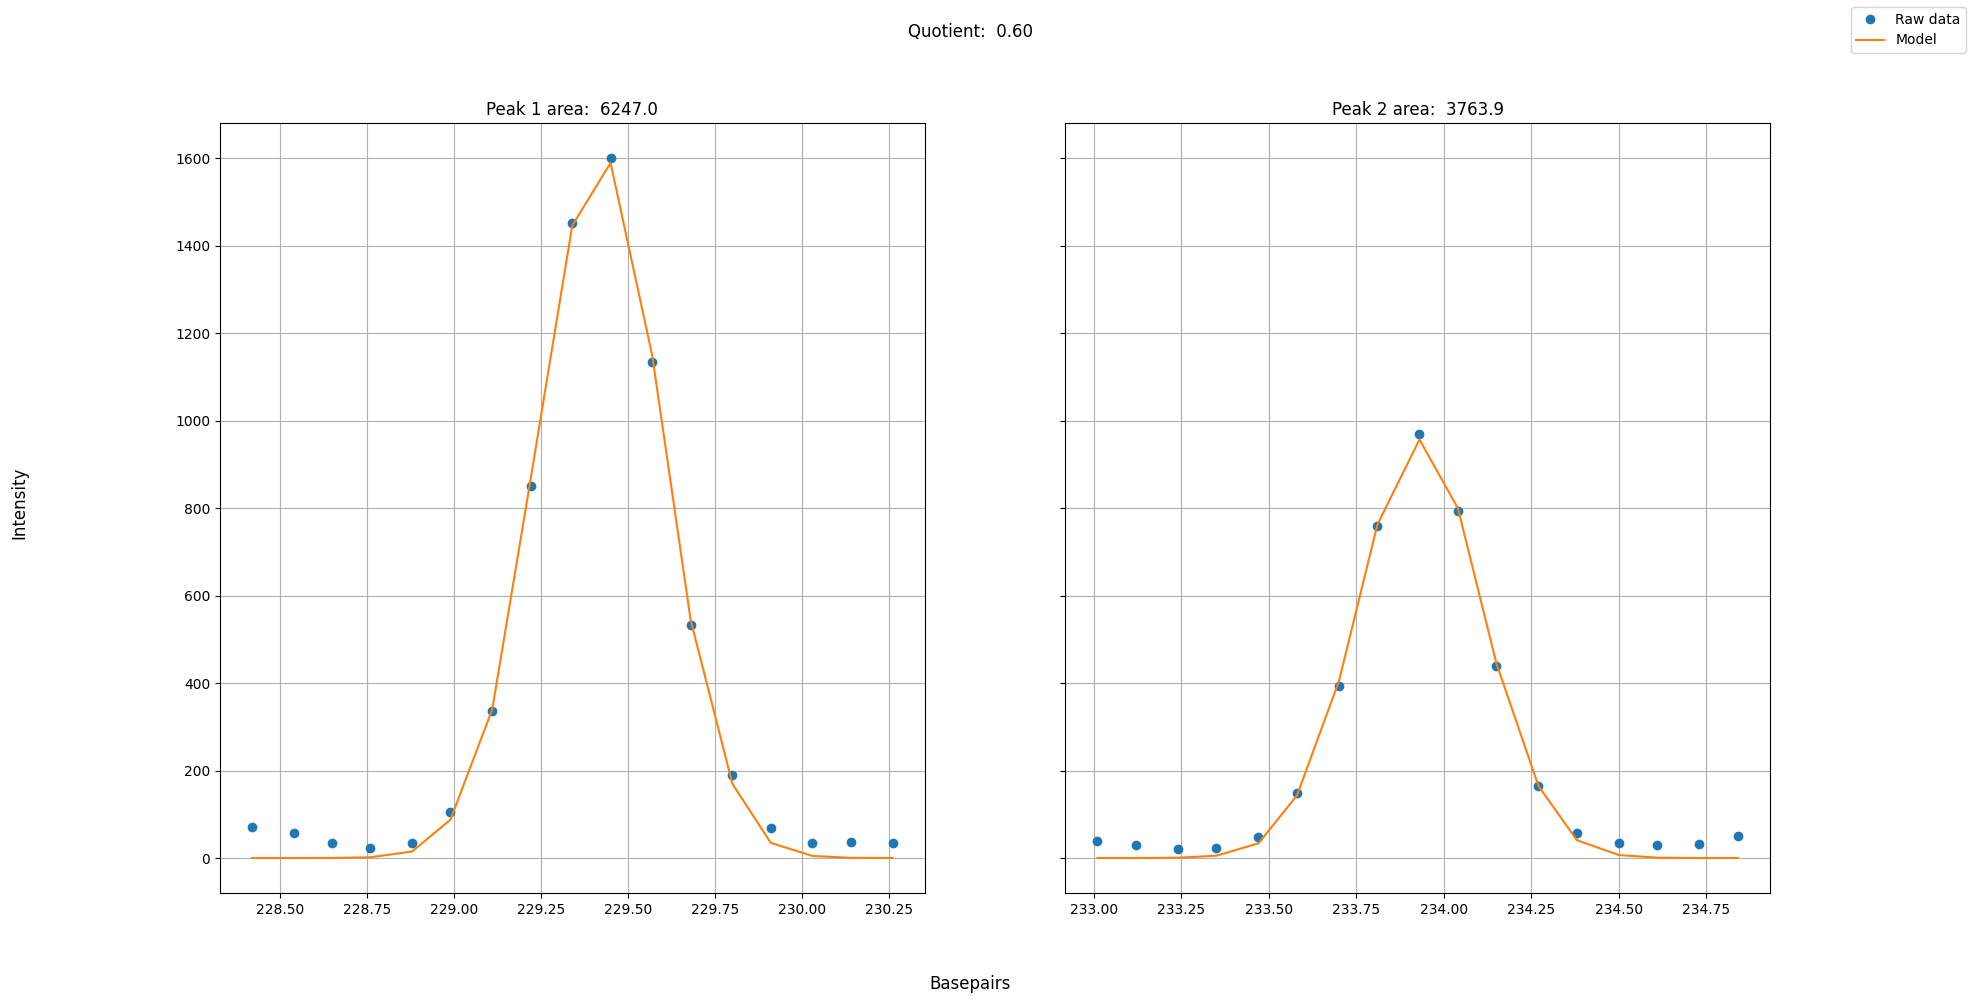

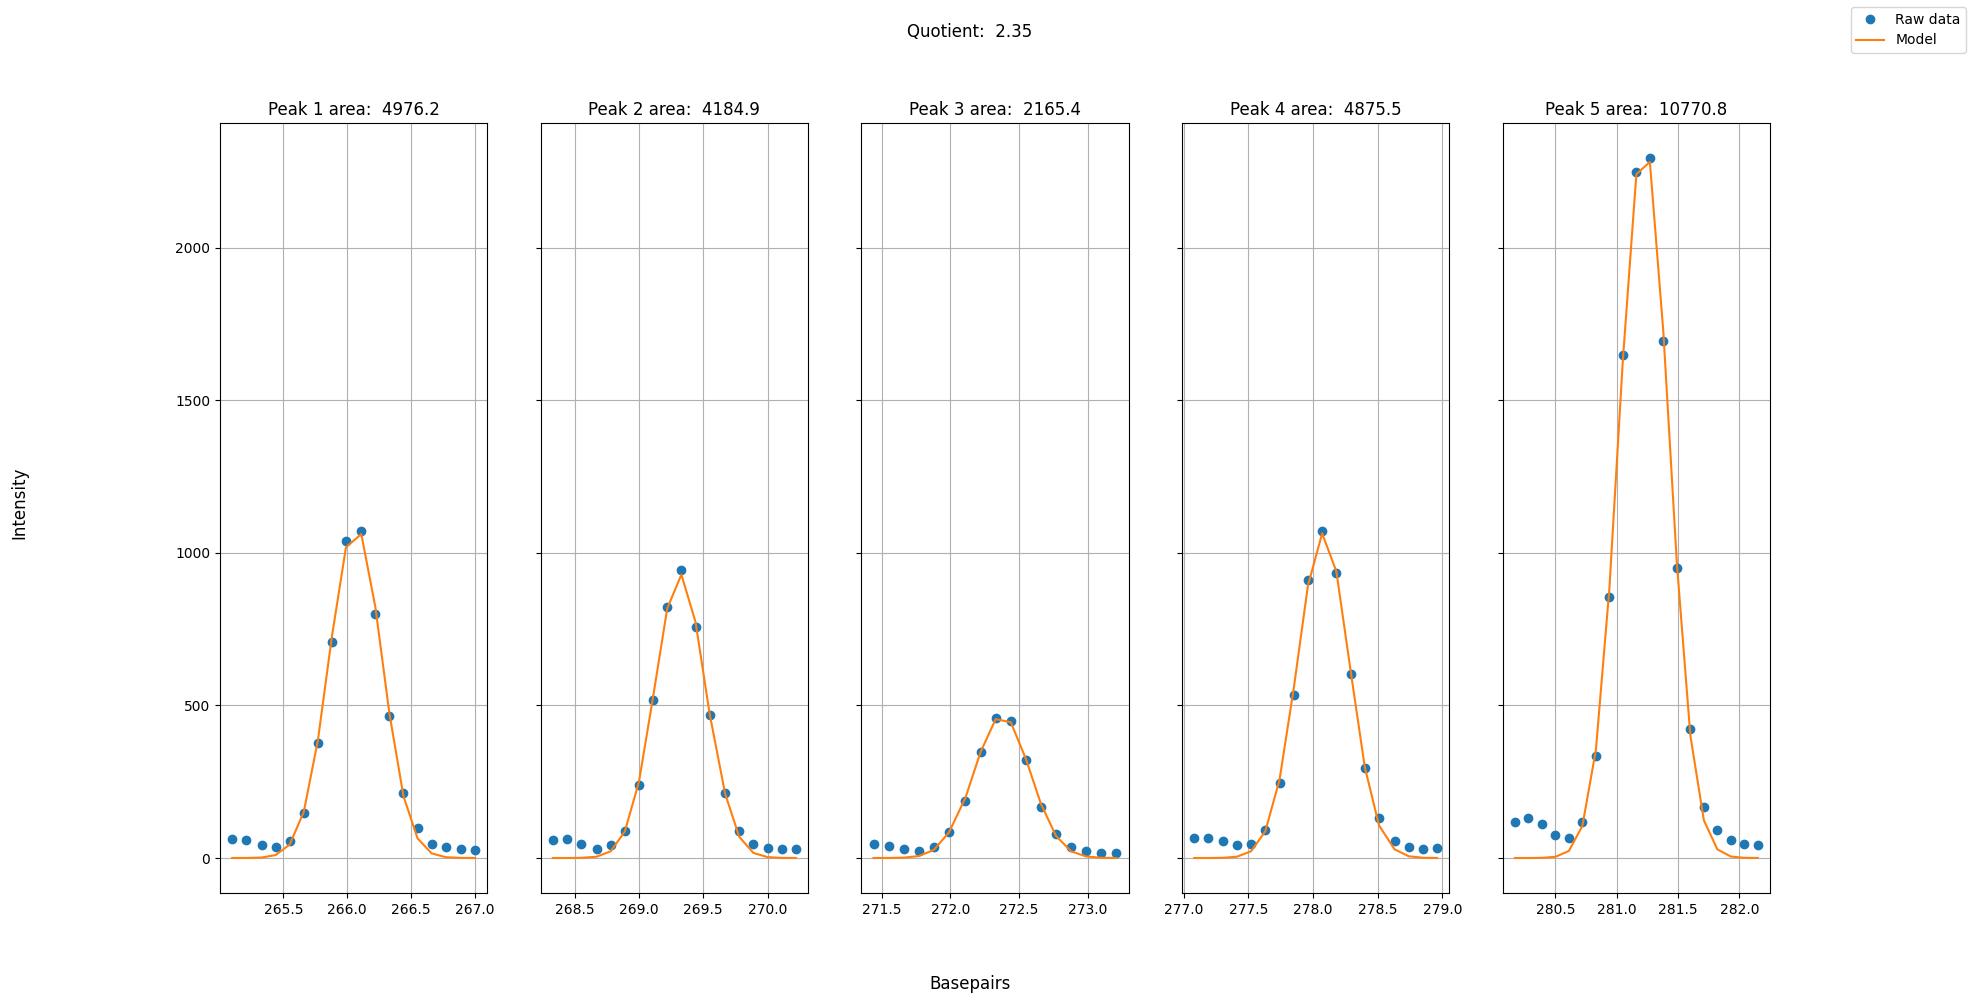

In [57]:
area_plots_list = fraggler.plot_areas(fsa)
for i, plot in enumerate(area_plots_list):
    display(plot)

In [58]:
for plot, name in fraggler.plot_fsa_data(fsa):
    display(plot)
    break


alt.Chart(...)